In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
sns.plotting_context(context='paper')
sns.set_palette('rainbow')

import pandas as pd
import prophet

In [19]:
sales = pd.read_csv('../../../data/mckinsey/sales.csv', index_col='ID')

skus = pd.read_csv('../../../data/mckinsey/sku.csv', index_col='SKU')

geo_params = pd.read_csv('../../../data/mckinsey/geo_params.csv', index_col='geoCluster')

sales = sales.join(skus, on='SKU')
sales = sales.join(geo_params, on='geoCluster')

In [20]:
sales.columns

Index(['geoCluster', 'SKU', 'date', 'price', 'sales', 'Category', 'Type',
       'brandId', 'lagerUnitQuantity', 'Units', 'trademark', 'countryOfOrigin',
       'Group', 'cityId'],
      dtype='object')

In [21]:
sales['date'] = pd.to_datetime(sales['date'])
sales.fillna(1, inplace=True)

In [22]:
timeframe_of_interest = pd.date_range(start=sales['date'].min(), end=sales['date'].max())

In [23]:
sales_per_day = sales.groupby('date')['sales'].sum().reindex(timeframe_of_interest, fill_value=0)

In [24]:
timeframe_of_interest = pd.date_range(start=sales['date'].min(), end=sales['date'].max())

In [25]:
additional_clusters_added = sales.groupby('geoCluster')['date'].min().reset_index().groupby('date')['geoCluster'].count()
geoclusters_cumsum = additional_clusters_added.reindex(timeframe_of_interest, fill_value=0).cumsum()

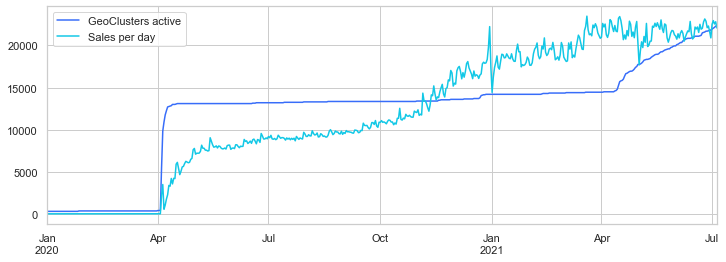

In [26]:
fig, ax = plt.subplots(figsize=(12, 4))

(geoclusters_cumsum * 50).plot(ax=ax, label='GeoClusters active')
sales_per_day.plot(ax=ax, label='Sales per day')
ax.legend()

In [27]:
full_training_set = sales_per_day.reset_index().rename(columns={'index': 'ds', 'sales': 'y'}).join(geoclusters_cumsum.rename('active_geoclusters'), on='ds')
full_training_set = full_training_set.sort_values(by='ds')

split_date = pd.to_datetime('2021-01-01')

training_set = full_training_set.loc[full_training_set['ds'] < split_date]
validation_set = full_training_set.loc[full_training_set['ds'] >= split_date]

In [35]:
m = prophet.Prophet(yearly_seasonality=False)
m.add_regressor('active_geoclusters', mode='multiplicative')
m.add_country_holidays(country_name='US')
m.fit(training_set)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [36]:
prediction = m.predict(full_training_set[['ds', 'active_geoclusters']])

C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method i

Text(0, 0.5, 'Sales')

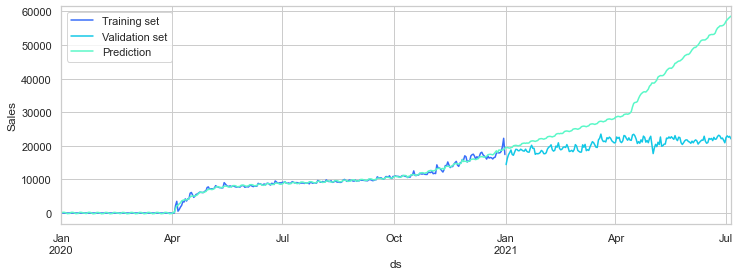

In [37]:
fig, ax = plt.subplots(figsize=(12, 4))

training_set.plot(ax=ax, x='ds', y='y', label='Training set')
validation_set.plot(ax=ax, x='ds', y='y', label='Validation set')
prediction.plot(ax=ax, x='ds', y='yhat', label='Prediction')

ax.set_ylabel('Sales')

This really shows the value of the cum active geocluster sum

#### Geocluster future development

In [38]:
test_set = pd.read_csv('../../../data/mckinsey/test.csv', index_col='ID')

In [39]:
timeframe_of_interest_test = pd.date_range(start=test_set['date'].min(), end=test_set['date'].max())

In [40]:
additional_clusters_added_test = test_set.groupby('geoCluster')['date'].min().reset_index().groupby('date')['geoCluster'].count()
geoclusters_cumsum_test = additional_clusters_added_test.reindex(timeframe_of_interest_test, fill_value=0).cumsum()

<AxesSubplot:>

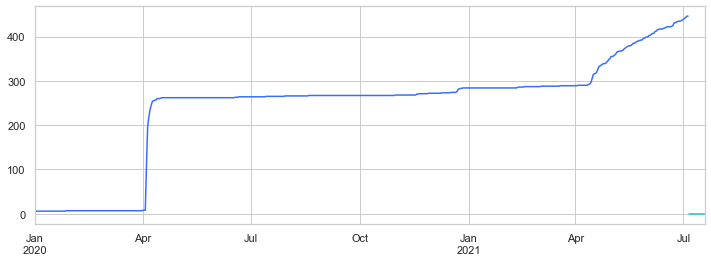

In [41]:
fig, ax = plt.subplots(figsize=(12, 4))

geoclusters_cumsum.plot(ax=ax, label='GeoClusters active')
geoclusters_cumsum_test.plot(ax=ax, label='GeoClusters active (future set)')